In [1]:
%cd /data/bruingjde/publications/SNAM2021-code/

from constants import *

/data/bruingjde/publications/SNAM2021-code


# I

In [2]:
def logistic_regression_I(network: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

I = {network: logistic_regression_I(network) for network in network_indices}

# Time aware

In [3]:
def logistic_regression_I_II_III_hypergraph(network: int):
  X = dict()
  # Type I features
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
    
  # Type II features
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1', 'm2', 'm3']:
        X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'))
  # Type III features      
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1']:
          X[(heuristic, time_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network:02}/features/time_edge/'
              f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

def logistic_regression_I_II_III_simplegraph(network: int):
  X = dict()
  # Type I
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
  # Type II 
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
        X[(time_strategy, nodepair_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}.npy'))
  # Type III
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      X[(heuristic, time_strategy)] = (
        np.load(
          f'data/{network:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy'))
      
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

time_aware_performance = {
  network: logistic_regression_I_II_III_hypergraph(network) 
  for network in hypergraph_indices} | {
  network: logistic_regression_I_II_III_simplegraph(network) 
  for network in simplegraph_indices
}

In [4]:
ylabel = 'time aware (AUC)'
xlabel = 'time agnostic (AUC)'

df = pd.concat(
  {
    ylabel: pd.Series(time_aware_performance), 
    xlabel: pd.Series(I)
  },
  axis=1)
df['category'] = get_networks()['category']

In [5]:
df.rename(columns={'category': 'Scientific domain'}, inplace=True)
df.replace({'Scientific domain': {'social': 'Social', 'information': 'Information', 'technological': 'Technological'}}, inplace=True)

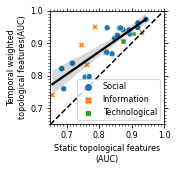

In [6]:
auc_values = df[[ylabel, xlabel]].values.flatten()
lim = (min(auc_values), 1)

fontsize=8
rc = {
  'xtick.top': True, 'ytick.right': True, 'figure.figsize': (3.30,2.475), 
  'axes.titlesize': fontsize, 
  'axes.labelsize': fontsize, 
  'xtick.labelsize': fontsize, 
  'ytick.labelsize': fontsize, 
  'legend.fontsize': fontsize, 
  'legend.title_fontsize': fontsize,
}

with plt.rc_context(rc):
  ax = sns.scatterplot(data=df, x=xlabel, y=ylabel, 
                  hue='Scientific domain', style='Scientific domain')
  sns.regplot(data=df, x=xlabel, y=ylabel, 
              scatter=False, color='black', ax=ax)
  ax.axline((0,0), (1,1), ls='--', c='black')
  ax.axis('scaled')
  ax.axis([.65, 1, .65, 1])
  ax.set_xlabel('Static topological features\n(AUC)')
  ax.set_ylabel('Temporal weighted\ntopological features(AUC)')
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  plt.legend()
  plt.tight_layout()
  plt.savefig('code/figures/output/results.pdf')

In [7]:
labels = networks.copy()
node = pd.read_pickle('code/figures/temp.pkl')
size = pd.read_pickle('code/figures/size.pkl')
IIb = pd.Series(pd.read_pickle('code/figures/IIb2.pkl'), name='q0')

In [8]:
merged = pd.concat(
  [df.round(3).drop(columns='Scientific domain'), 
   labels, 
   node.round(3).drop(columns='category'), 
   size, 
   IIb.round(3)
  ], axis=1)
merged['q0'].fillna(merged['time aware (AUC)'], inplace=True)
merged['edge type'] = pd.Series(merged.index.isin(hypergraph_indices), 
                           index=merged.index)
merged['edge type'].replace({True: 'multi', False: 'simple'}, 
                       inplace=True)

In [9]:
rename_columns = {
  'time agnostic (AUC)': 'I', 
  'q0': 'II-B',
  'time aware (AUC)': 'II-A', 
  'auc (node activity + static features)': 'III',
  'category': 'Scientific domain'
}
cols = ['label', 'Scientific domain', 'edge type', 'nodes', 'I', 'II-A', 'II-B', 'III']
table = merged.rename(columns=rename_columns).loc[:, cols]
table.replace({'Scientific domain': {'social': 'Social', 'information': 'Information', 'technological': 'Technological'}}, inplace=True)
table.sort_values(['nodes'], inplace=True)

In [10]:
def thousand_sep(x):
  return f'{x:,}'

In [11]:
latex_table = table.to_latex(
  index=False,
  column_format=
    'l@{\hspace{1em}}c@{\hspace{1em}}c@{\hspace{1em}}r'
    + 4*'@{\hspace{1em}}c',
  caption='Performance obtained for feature set I-III.',
  formatters={'nodes': thousand_sep},
  label='table:results',
  escape=False,
  multicolumn=False)
print(latex_table)

\begin{table}
\centering
\caption{Performance obtained for feature set I-III.}
\label{table:results}
\begin{tabular}{l@{\hspace{1em}}c@{\hspace{1em}}c@{\hspace{1em}}r@{\hspace{1em}}c@{\hspace{1em}}c@{\hspace{1em}}c@{\hspace{1em}}c}
\toprule
label & Scientific domain & edge type &     nodes &     I &  II-A &  II-B &   III \\
\midrule
 Rado &            Social &     multi &       167 & 0.856 & 0.924 & 0.852 & 0.902 \\
   UC &       Information &     multi &       899 & 0.746 & 0.894 & 0.744 & 0.873 \\
   EU &            Social &     multi &       986 & 0.824 & 0.872 & 0.811 & 0.849 \\
  Dem &            Social &     multi &     1,891 & 0.919 & 0.948 & 0.919 & 0.938 \\
 bitA &            Social &    simple &     3,683 & 0.862 & 0.946 & 0.946 & 0.940 \\
bitOT &            Social &    simple &     5,573 & 0.825 & 0.947 & 0.947 & 0.939 \\
chess &       Information &    simple &     6,050 & 0.656 & 0.741 & 0.741 & 0.736 \\
HepTh &       Information &     multi &     6,798 & 0.763 & 0.833 & 0.

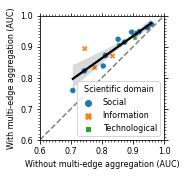

In [12]:
x_label = 'II-B'
y_label = 'II-A'

data = table[table['edge type'] == 'multi']

auc_values = table[[x_label, y_label]].values.flatten()
lim = (.6, 1)

with plt.rc_context(rc):
  ax = sns.scatterplot(data=data, x=x_label, y=y_label, hue='Scientific domain', 
                  style='Scientific domain')
  sns.regplot(data=data, x=x_label, y=y_label, scatter=False, color='black', ax=ax)
  ax.axline((0,0), (1,1), ls='--', c='grey')
  ax.axis('scaled')
  ax.axis([.6, 1, .6, 1])

  plt.xlabel('Without multi-edge aggregation (AUC)')
  plt.ylabel('With multi-edge aggregation (AUC)')
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  plt.tight_layout()
  plt.savefig('code/figures/output/aggregation.pdf')

In [13]:
data['II-A']

from scipy.stats.stats import pearsonr
pearsonr(data['II-A'], data['II-B'])

(0.9150881482185772, 6.801825064874117e-07)

In [14]:
(table['II-A'] - table['I']).agg(['mean', 'std'])

mean    0.065538
std     0.042410
dtype: float64

In [15]:
import scipy.stats

scipy.stats.normaltest(table['II-A'] - table['I'])

NormaltestResult(statistic=3.512966403788539, pvalue=0.17265097603669355)

In [16]:
stats = get_all_stats(network_indices=network_indices) 

  0%|          | 0/26 [00:00<?, ?it/s]

In [17]:
stats['degree assortativity']

1     0.114186
2     0.059906
3    -0.166689
4     0.221522
5     0.177355
6     0.010808
7     0.155727
8     0.221522
9     0.008341
10   -0.055707
11   -0.227284
12   -0.294441
13   -0.092248
14   -0.197902
16   -0.051317
18   -0.153884
19   -0.301404
20   -0.144884
21    0.335905
22   -0.143106
23   -0.087745
24   -0.078326
25   -0.064984
28   -0.087156
29   -0.137222
30   -0.025743
Name: degree assortativity, dtype: float64

In [18]:
table

,label,Scientific domain,edge type,nodes,I,II-A,II-B,III
12,Rado,Social,multi,167,0.856,0.924,0.852,0.902
13,UC,Information,multi,899,0.746,0.894,0.744,0.873
30,EU,Social,multi,986,0.824,0.872,0.811,0.849
19,Dem,Social,multi,1891,0.919,0.948,0.919,0.938
18,bitA,Social,simple,3683,0.862,0.946,0.946,0.940
20,bitOT,Social,simple,5573,0.825,0.947,0.947,0.939
21,chess,Information,simple,6050,0.656,0.741,0.741,0.736
6,HepTh,Information,multi,6798,0.763,0.833,0.776,0.819
2,HepPh,Information,multi,16959,0.820,0.870,0.834,0.868
5,Condm,Social,multi,17218,0.691,0.759,0.706,0.728
